## Tree Classifiers

### Decision Tree Construction Algorithm

#### We build a tree top-down in a greedy manner.

    function BuildDT(X, Y, threshold)
        if (all the labels (Y) are the same
            assign as leaf node with label set to class of Y
            return tree
        elseif (threshold is the minimum number of examples to keep)
            assign as leaf node with label set to most commin class
            return tree
        else
            let f be the feature that is best to split on
            let leftChildBranch = BuildDT(data (X) where f=True, labels (Y) with f=True)
            let rightChildBranch = BuildDT(data (X) where f=False, labels (Y) with f=False)
            return tree
            
### Determining best split feature by evaluating node purity

<img style="float: l;" src="./images/Purity.png">
 
$Entropy(t) = - \displaystyle \sum_{i=0}^{c-1} p(\space i \space | \space t \space) \space log_2 \space p(\space i \space | \space t \space) \space \space \space \space \space \space \space \space \space \space Gini(t) = 1 - \displaystyle \sum_{i=0}^{c-1} [p(\space i \space | \space t \space)]^2 \space \space \space \space \space \space \space \space \space \space Classification \space error(t) = 1 - \max_i [p(\space i \space | \space t \space)]$

#### 1) Determine which feature is better to split on ?
<img style="float: left;" src="./images/Gini.png">  $ A.N1 = 1 - (4/7)^2 + (3/7)^2 = 0.4898 \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space$
                                           $ A.N2 = 1 - (2/5)^2 + (3/5)^2 = 0.4800 \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space \space$
                                           $A = (7/12) x 0.4898 + (5/12) X 0.4800 = 0.486$ 


                                           
### Environment Setup

In [5]:
import re
import nltk
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
%matplotlib inline 
import matplotlib.pyplot as plt

### Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [6]:
def tokenize(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [ token for token in tokens if re.search('(^[a-zA-Z]+$)', token) ]
    return filtered_tokens

cachedStopWords = stopwords.words("english") + ['year', 'old', 'man', 'woman', 'ap', 'am', 'pm', 'portable', 'pa', 'lat', 'admitting', 'diagnosis', 'lateral']


### Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [8]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpusList = list(corpus.values())
labels = list(corpus.keys())

### Generate Document-Term Frequency Counts

#### In this step we tokenize our text and remove stop words in addition to generating our frequency counts.

#### 1) How many documents are we working with and how many features (unigrams & bigrams)?

#### 2) Can you figure out what max_df and min_df is doing to our feature count?

In [9]:
cv = CountVectorizer(lowercase=True, max_df=0.80, max_features=None, min_df=0.033,
                     ngram_range=(1, 2), preprocessor=None, stop_words=cachedStopWords,
                     strip_accents=None, tokenizer=tokenize, vocabulary=None)
X = cv.fit_transform(corpusList)
print(X.shape)
print()
lexicon = cv.get_feature_names()
print (lexicon)
print()

(1500, 773)

['abd', 'abdomen', 'abdomen contrast', 'abdomen pelvis', 'abdominal', 'abnormalities', 'acquired', 'acute', 'acute sob', 'addition', 'adjacent', 'administered', 'administration', 'adrenal', 'adrenal glands', 'air', 'air space', 'airspace', 'allowing', 'along', 'also', 'also noted', 'although', 'alveolar', 'amount', 'amt', 'amt final', 'amt underlying', 'angle', 'anterior', 'aorta', 'aortic', 'aortic stenosis', 'apex', 'apical', 'apices', 'appear', 'appearance', 'appears', 'approximately', 'approximately cm', 'area', 'areas', 'arrest', 'arteries', 'artery', 'ascites', 'aspect', 'aspiration', 'assess', 'associated', 'atelectasis', 'atelectasis left', 'atrial', 'atrium', 'attenuation', 'available', 'axial', 'axial images', 'axillary', 'base', 'bases', 'basilar', 'bibasilar', 'bilateral', 'bilateral pleural', 'bilateral pulmonary', 'bilaterally', 'bladder', 'bleed', 'blunting', 'bone', 'bone windows', 'bowel', 'breath', 'c', 'ca', 'cabg', 'cad', 'cad chf', 'calcification', 'ca

### Construct our Classes

#### We need to assign a class for each classification. We typically assign numeric values to classes.

In [10]:
Y = []
for key in corpus:        
    if (key.startswith('COPD') or key.startswith('CHF')):
        Y.append(0)
    elif (key.startswith('PNA')):
        Y.append(1)
Y = np.array(Y)

### Let's Run It!

#### We will generate models and evaluate the modes using 10-fold cross-validation.

In [11]:
results = []
cont = []
kf = KFold(n_splits=10, shuffle=True)
K = [1, 3, 5, 10, 15, 20, 40]
for k in range(len(K)):
    fold = 1
    truth = []
    dt_prediction = []
    print("model ", k, ": DT K = " + str(K[k]))
    test_count = 0
    dt = DecisionTreeClassifier(random_state=0, min_samples_leaf=K[k], criterion="entropy")
    for train_idx, test_idx in kf.split(X):
        trainX = X[train_idx]
        trainY = Y[train_idx]
        testX = X[test_idx]
        testY = Y[test_idx]
        truth.append(testY)
        dt.fit(trainX, trainY)
        Y_hat = dt.predict(testX)
        dt_prediction.append(Y_hat)
        print("   Fold %d accuracy: %.2f %%" % (fold, ((np.sum(Y_hat == testY)/len(testY)) * 100.0)))                        
        fold += 1
    truth = np.concatenate(truth, axis=0)    
    dt_prediction = np.concatenate(dt_prediction, axis=0)
    test_results = np.sum(dt_prediction == truth)/len(truth)
    print("     Overall test accuracy: %.2f %%" % (test_results * 100))  
    dt = dt.fit(X, Y)
    Y_hat = dt.predict(X)
    train_results = np.sum(Y_hat == Y)/len(Y)
    print("     Overall training accuracy: %.2f %%" % (train_results * 100.0))  
    results.append([train_results, test_results])   
    cont.append([truth, dt_prediction])



model  0 : DT K = 1
   Fold 1 accuracy: 91.33 %
   Fold 2 accuracy: 97.33 %
   Fold 3 accuracy: 92.67 %
   Fold 4 accuracy: 93.33 %
   Fold 5 accuracy: 94.67 %
   Fold 6 accuracy: 92.00 %
   Fold 7 accuracy: 96.67 %
   Fold 8 accuracy: 89.33 %
   Fold 9 accuracy: 96.00 %
   Fold 10 accuracy: 92.00 %
     Overall test accuracy: 93.53 %
     Overall training accuracy: 100.00 %
model  1 : DT K = 3
   Fold 1 accuracy: 84.67 %
   Fold 2 accuracy: 89.33 %
   Fold 3 accuracy: 94.67 %
   Fold 4 accuracy: 84.67 %
   Fold 5 accuracy: 94.67 %
   Fold 6 accuracy: 85.33 %
   Fold 7 accuracy: 93.33 %
   Fold 8 accuracy: 94.00 %
   Fold 9 accuracy: 92.00 %
   Fold 10 accuracy: 87.33 %
     Overall test accuracy: 90.00 %
     Overall training accuracy: 98.40 %
model  2 : DT K = 5
   Fold 1 accuracy: 94.67 %
   Fold 2 accuracy: 91.33 %
   Fold 3 accuracy: 92.67 %
   Fold 4 accuracy: 89.33 %
   Fold 5 accuracy: 90.67 %
   Fold 6 accuracy: 90.00 %
   Fold 7 accuracy: 90.67 %
   Fold 8 accuracy: 90.00 %
 

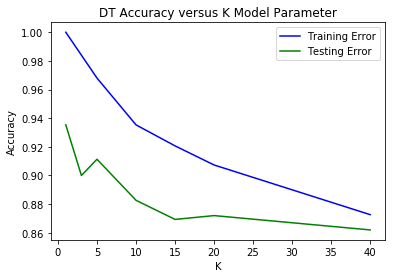

In [12]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

trainAcc = plt.plot(K, tracc, '-b', label='Training Error')
testACC = plt.plot(K, tstacc, '-g', label='Testing Error')
plt.title("DT Accuracy versus K Model Parameter")
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.legend(loc=1)
plt.show(block=False)

### Contingency Tables

#### Let's look at the contingency tables

#### 1) Can you calculate the Sensitivity, Specificity, PPV, NPV? 

In [13]:
model = input("Enter Best Model: ")
best = cont[int(model)]
dt_ct = pd.crosstab(best[1], best[0], margins=True)
dt_ct.columns = ["Other", "PNA", "Total"]
dt_ct.index = ["Other", "PNA", "Total"]
print()
print("Decision Tree")
print(dt_ct)
print()


Enter Best Model: 2

Decision Tree
       Other  PNA  Total
Other    947   80   1027
PNA       53  420    473
Total   1000  500   1500



### Evaluation Statistics

#### We will calculate some test statistics for our classifiers

In [14]:
Sens = dt_ct.iloc[1][1]/dt_ct.iloc[2][1]
Spec = dt_ct.iloc[0][0]/dt_ct.iloc[2][0]
PPV = dt_ct.iloc[1][1]/dt_ct.iloc[1][2]
NPV = dt_ct.iloc[0][0]/dt_ct.iloc[0][2]
ACC = (dt_ct.iloc[0][0] + dt_ct.iloc[1][1]) / dt_ct.iloc[2][2]
print("Decision Tree: Sensitivity: %.5f Specificity: %.5f PPV: %.5f NPV: %.5f Accuracy: %.5f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Decision Tree: Sensitivity: 0.84000 Specificity: 0.94700 PPV: 0.88795 NPV: 0.92210 Accuracy: 0.91133


### ROC Curve

#### 1) So which classifier do you think is better?

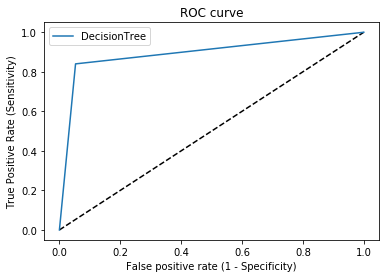

AUC =  0.8935


In [16]:
dt_fpr, dt_tpr, dt_thresholds = roc_curve(best[0], best[1], pos_label=1)
roc_auc = auc(dt_fpr, dt_tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(dt_fpr, dt_tpr, label='DecisionTree')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)